In [5]:
if 'google.colab' in str(get_ipython()):
    ! git clone -b main https://github.com/edsonportosilva/OptiCommPy
    from os import chdir as cd
    cd('/content/OptiCommPy/')
    ! pip install .

Cloning into 'OptiCommPy'...
remote: Enumerating objects: 10903, done.
remote: Counting objects: 100% (2042/2042), done.
remote: Compressing objects: 100% (223/223), done.
remote: Total 10903 (delta 1911), reused 1885 (delta 1819), pack-reused 8861 (from 1)
Receiving objects: 100% (10903/10903), 197.61 MiB | 28.60 MiB/s, done.
Resolving deltas: 100% (8190/8190), done.
Processing /content/OptiCommPy
  Preparing metadata (setup.py) ... done
  Created wheel for OptiCommPy: filename=OptiCommPy-0.9.0-py3-none-any.whl size=81662 sha256=7ba6d316f7dee4150896860de0dc6eeca2af033aeb2d54092f2d9e2ac51e818d
  Stored in directory: /tmp/pip-ephem-wheel-cache-vqm_v0mt/wheels/0a/b3/b4/c1f785c2fbf2de32a986f34e6d5146d854df27f3012a7f465d
Successfully built OptiCommPy
  Attempting uninstall: OptiCommPy
    Found existing installation: OptiCommPy 0.9.0
    Uninstalling OptiCommPy-0.9.0:
      Successfully uninstalled OptiCommPy-0.9.0


In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from scipy.special import erfc
import time

===== SIMULATION OF DIGITAL COHERENT OPTICAL SYSTEM =====
Modulation: 16-QAM
Symbol rate: 50.0 GBaud
Roll-off factor (β): 0.1
Phase mismatch (δφ): 0.1
Phase shift: φ = (1+δφ)π/2 = 1.7279 radians = 99.00 degrees
Number of symbols: 100000
Starting simulation...
Simulating BER vs OSNR curve...
OSNR = 10 dB: BER (simulated) = 0.518835, BER (theoretical) = 0.001754
OSNR = 12 dB: BER (simulated) = 0.518980, BER (theoretical) = 0.000139
OSNR = 14 dB: BER (simulated) = 0.519105, BER (theoretical) = 0.000003
OSNR = 16 dB: BER (simulated) = 0.519531, BER (theoretical) = 0.000000
OSNR = 18 dB: BER (simulated) = 0.519273, BER (theoretical) = 0.000000
OSNR = 20 dB: BER (simulated) = 0.519276, BER (theoretical) = 0.000000
OSNR = 22 dB: BER (simulated) = 0.519496, BER (theoretical) = 0.000000
OSNR = 24 dB: BER (simulated) = 0.519534, BER (theoretical) = 0.000000
OSNR = 26 dB: BER (simulated) = 0.519386, BER (theoretical) = 0.000000
OSNR = 28 dB: BER (simulated) = 0.519419, BER (theoretical) = 0.00000

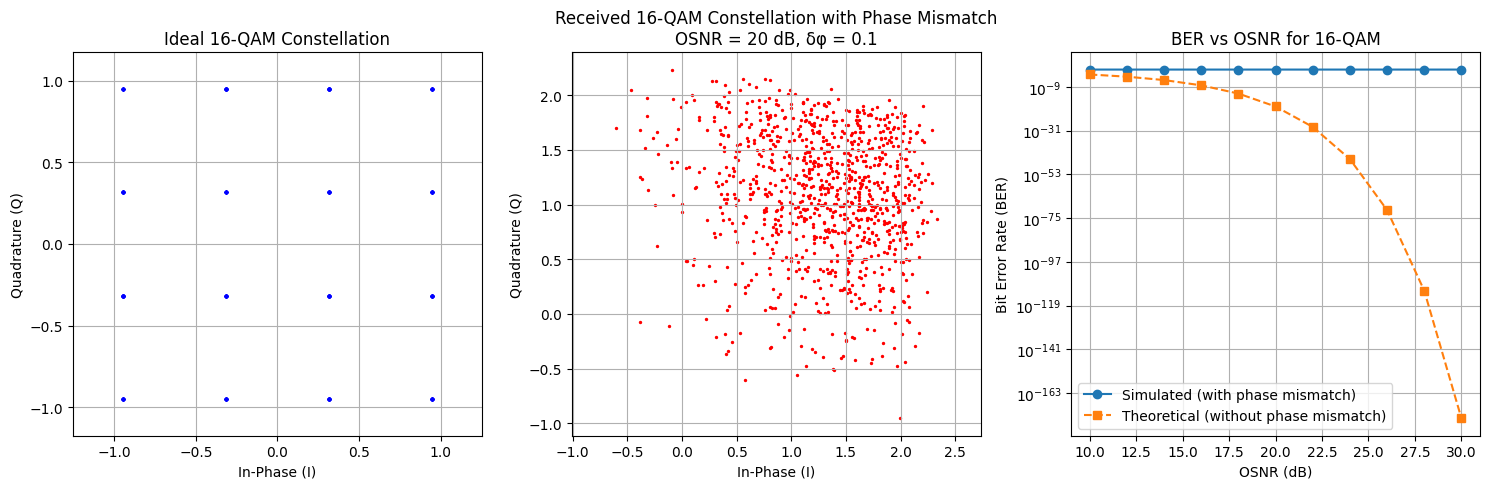

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from scipy.special import erfc
import time

# ===== SIMULATION PARAMETERS =====
# System parameters as specified in the problem
sym_rate = 50e9          # Symbol rate: 50 GBaud
beta = 0.1               # Roll-off factor for RRC filter
phase_mismatch = 0.1     # Phase mismatch parameter δφ
M = 16                   # Modulation order (16-QAM)

# Simulation parameters
num_symbols = 100000     # Number of symbols to simulate
sps = 4                  # Samples per symbol
bits_per_symbol = int(np.log2(M))  # 4 bits per symbol
num_taps = 1001          # Filter taps for pulse shaping

print(f"===== SIMULATION OF DIGITAL COHERENT OPTICAL SYSTEM =====")
print(f"Modulation: 16-QAM")
print(f"Symbol rate: {sym_rate/1e9} GBaud")
print(f"Roll-off factor (β): {beta}")
print(f"Phase mismatch (δφ): {phase_mismatch}")
print(f"Phase shift: φ = (1+δφ)π/2 = {(1+phase_mismatch)*np.pi/2:.4f} radians = {(1+phase_mismatch)*90:.2f} degrees")
print(f"Number of symbols: {num_symbols}")
print("="*50)

# ===== ROOT RAISED COSINE FILTER IMPLEMENTATION =====
def root_raised_cosine(t, sps, beta):
    """
    Generate a root raised cosine filter impulse response.
    t: time indices (centered around 0)
    sps: samples per symbol
    beta: roll-off factor
    """
    rrc_taps = np.zeros_like(t, dtype=float)
    Ts = sps  # Symbol period in samples

    # Handle the special case at t=0
    rrc_taps[t == 0] = (1 - beta + 4*beta/np.pi)

    # Handle the special case at t = ±Ts/(4*beta)
    if beta > 0:
        special_t = Ts/(4*beta)
        special_indices = np.isclose(np.abs(t), special_t)
        special_val = (beta/np.sqrt(2)) * (
            (1 + 2/np.pi) * np.sin(np.pi/(4*beta)) +
            (1 - 2/np.pi) * np.cos(np.pi/(4*beta))
        )
        rrc_taps[special_indices] = special_val

        # Handle the general case - implement without complex indexing
        general_indices = ~np.isclose(t, 0) & ~special_indices
        for i in range(len(t)):
            if general_indices[i]:
                t_val = t[i]
                if not np.isclose(t_val, 0) and not np.isclose(np.abs(t_val), special_t):
                    numerator = np.sin(np.pi*t_val/Ts * (1-beta)) + 4*beta*t_val/Ts * np.cos(np.pi*t_val/Ts * (1+beta))
                    denominator = np.pi*t_val/Ts * (1 - (4*beta*t_val/Ts)**2)

                    if not np.isclose(denominator, 0):
                        rrc_taps[i] = numerator / denominator
    else:
        # When beta=0, it's a sinc pulse
        non_zero = t != 0
        rrc_taps[non_zero] = np.sin(np.pi*t[non_zero]/Ts) / (np.pi*t[non_zero]/Ts)

    return rrc_taps

# ===== 16-QAM MAPPING FUNCTIONS =====
def bits_to_16qam(bits):
    """
    Map bits to 16-QAM symbols using Gray coding
    """
    symbols = []
    for i in range(0, len(bits), 4):
        if i+3 < len(bits):  # Ensure we have 4 bits
            # Gray coding for 16-QAM
            b0, b1, b2, b3 = bits[i], bits[i+1], bits[i+2], bits[i+3]

            # Map to constellation points (-3, -1, 1, 3)
            I = 2*(1 - 2*b0) + (1 - 2*b1)
            Q = 2*(1 - 2*b2) + (1 - 2*b3)

            # Create complex symbol
            symbols.append(complex(I, Q))

    # Convert to numpy array
    symbols = np.array(symbols)

    # Normalize for unit average power
    scale = 1/np.sqrt(10)  # For 16-QAM
    return symbols * scale

def qam16_to_bits(symbols, scale=1/np.sqrt(10)):
    """
    Convert 16-QAM symbols back to bits
    """
    bits = []

    # Rescale symbols
    symbols = symbols / scale

    for symbol in symbols:
        # Extract I and Q components
        I = np.real(symbol)
        Q = np.imag(symbol)

        # Decision thresholds for 16-QAM (-3, -1, 1, 3)
        b0 = 0 if I < 0 else 1  # MSB of I
        b1 = 1 if abs(I) < 2 else 0  # LSB of I
        b2 = 0 if Q < 0 else 1  # MSB of Q
        b3 = 1 if abs(Q) < 2 else 0  # LSB of Q

        # Add bits to the sequence
        bits.extend([b0, b1, b2, b3])

    return np.array(bits)

# ===== MZM MODULATOR =====
def mzm_modulator(signal, vpi=1.0, bias=0.5):
    """
    Simulate Mach-Zehnder Modulator for optical signal modulation
    """
    # Normalize signal amplitude for proper MZM operation
    signal_max = np.max(np.abs(signal))
    if signal_max > 0:
        normalized_signal = signal / signal_max
    else:
        normalized_signal = signal

    # Split into I and Q components
    I = np.real(normalized_signal)
    Q = np.imag(normalized_signal)

    # Apply MZM transfer function to each component
    # E_out = cos(π·v_in/(2·Vπ) + π·bias/2)
    I_out = np.cos(np.pi * I / (2 * vpi) + np.pi * bias / 2)
    Q_out = np.cos(np.pi * Q / (2 * vpi) + np.pi * bias / 2)

    # Combine to form complex output
    output = I_out + 1j * Q_out

    return output

# ===== RECEIVER FRONT-END WITH PHASE MISMATCH =====
def receiver_frontend(signal, phase_shift):
    """
    Simulate coherent receiver front-end with phase mismatch
    """
    # Calculate actual phase shift
    phi = (1 + phase_shift) * np.pi/2

    # In a coherent receiver, the incoming optical signal is mixed with
    # a local oscillator in two balanced photodetectors
    # Ideally, they are 90° apart, but with phase mismatch we have:

    # I-component (in-phase)
    I = np.real(signal)

    # Q-component (quadrature) with phase error
    # Instead of being orthogonal, it's at phi angle
    Q = np.imag(signal * np.exp(-1j * (phi - np.pi/2)))

    # Combine to form received complex signal
    received = I + 1j * Q

    return received

# ===== AWGN CHANNEL =====
def add_awgn(signal, osnr_db):
    """
    Add Amplified Spontaneous Emission (ASE) noise based on OSNR
    """
    # Calculate signal power
    signal_power = np.mean(np.abs(signal)**2)

    # OSNR is defined in a reference bandwidth (typically 0.1nm or ~12.5GHz at 1550nm)
    # We need to scale based on our simulation bandwidth
    sim_bandwidth = sym_rate * (1 + beta)  # Bandwidth of our signal
    ref_bandwidth = 12.5e9  # Reference bandwidth (0.1nm at 1550nm)
    bandwidth_ratio = sim_bandwidth / ref_bandwidth

    # Calculate noise power based on OSNR
    osnr_linear = 10**(osnr_db/10)
    noise_power = signal_power / (osnr_linear * bandwidth_ratio)

    # Generate complex AWGN noise
    noise = np.sqrt(noise_power/2) * (np.random.normal(0, 1, len(signal)) +
                                     1j * np.random.normal(0, 1, len(signal)))

    # Add noise to signal
    noisy_signal = signal + noise

    return noisy_signal

# ===== BER CALCULATION =====
def calculate_ber(original_bits, received_bits):
    """
    Calculate Bit Error Rate
    """
    # Make sure both bit sequences have the same length
    min_len = min(len(original_bits), len(received_bits))
    original_bits = original_bits[:min_len]
    received_bits = received_bits[:min_len]

    # Count bit errors
    errors = np.sum(original_bits != received_bits)

    # Calculate BER
    ber = errors / len(original_bits) if len(original_bits) > 0 else 1.0

    return ber

# ===== THEORETICAL BER FOR 16-QAM =====
def theoretical_ber_16qam(osnr_db):
    """
    Calculate theoretical BER for 16-QAM in AWGN channel
    """
    # Convert OSNR to SNR per bit
    snr_linear = 10**(osnr_db/10)

    # For 16-QAM, BER ≈ (3/8)*erfc(sqrt(SNR_per_bit*2/5))
    # Factor 2/5: 16-QAM uses 4 bits per symbol with avg energy 10
    ber = 3/8 * erfc(np.sqrt(snr_linear * 2/5))

    return ber

# ===== START SIMULATION =====
print("Starting simulation...")
start_time = time.time()

# Generate random bits
np.random.seed(42)  # For reproducibility
total_bits = num_symbols * bits_per_symbol
bits = np.random.randint(0, 2, total_bits)

# Map bits to 16-QAM symbols
symbols = bits_to_16qam(bits)

# Plot ideal constellation
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.scatter(np.real(symbols[:1000]), np.imag(symbols[:1000]), color='blue', s=2)
plt.grid(True)
plt.title('Ideal 16-QAM Constellation')
plt.xlabel('In-Phase (I)')
plt.ylabel('Quadrature (Q)')
plt.axis('equal')

# Upsample symbols to apply pulse shaping
upsampled = np.zeros(len(symbols) * sps, dtype=complex)
upsampled[::sps] = symbols

# Design RRC filter
t = np.arange(-num_taps//2, num_taps//2 + 1)
rrc = root_raised_cosine(t, sps, beta)
rrc = rrc / np.sqrt(np.sum(rrc**2))  # Normalize for unit energy

# Apply RRC pulse shaping
tx_signal = signal.lfilter(rrc, 1, upsampled)

# Apply MZM modulation
modulated_signal = mzm_modulator(tx_signal)

# Simulate BER vs OSNR
osnr_range = np.arange(10, 31, 2)  # OSNR range in dB
ber_simulated = []
ber_theoretical = []

# Plot constellation at a specific OSNR
constellation_osnr = 20  # dB for constellation plot

# For constellation at specific OSNR
noisy_signal_for_const = add_awgn(modulated_signal, constellation_osnr)
received_signal_for_const = receiver_frontend(noisy_signal_for_const, phase_mismatch)
matched_filtered_for_const = signal.lfilter(rrc, 1, received_signal_for_const)
downsampled_for_const = matched_filtered_for_const[num_taps-1::sps]  # Account for filter delay
downsampled_for_const = downsampled_for_const[:min(len(symbols), len(downsampled_for_const))]

# Plot received constellation with phase mismatch
plt.subplot(1, 3, 2)
plt.scatter(np.real(downsampled_for_const[:1000]), np.imag(downsampled_for_const[:1000]), color='red', s=2)
plt.grid(True)
plt.title(f'Received 16-QAM Constellation with Phase Mismatch\nOSNR = {constellation_osnr} dB, δφ = {phase_mismatch}')
plt.xlabel('In-Phase (I)')
plt.ylabel('Quadrature (Q)')
plt.axis('equal')

print(f"Simulating BER vs OSNR curve...")
# Simulate for each OSNR value
for osnr in osnr_range:
    # Add noise
    noisy_signal = add_awgn(modulated_signal, osnr)

    # Apply receiver front-end with phase mismatch
    received_signal = receiver_frontend(noisy_signal, phase_mismatch)

    # Apply matched filter (RRC)
    matched_filtered = signal.lfilter(rrc, 1, received_signal)

    # Downsample to symbol rate and account for filter delay
    downsampled = matched_filtered[num_taps-1::sps]
    downsampled = downsampled[:min(len(symbols), len(downsampled))]

    # Make symbol decisions and calculate BER
    decided_bits = qam16_to_bits(downsampled)
    decided_bits = decided_bits[:min(len(bits), len(decided_bits))]

    # Calculate BER
    ber = calculate_ber(bits[:len(decided_bits)], decided_bits)
    ber_simulated.append(ber)

    # Calculate theoretical BER for 16-QAM
    ber_theory = theoretical_ber_16qam(osnr)
    ber_theoretical.append(ber_theory)

    print(f"OSNR = {osnr} dB: BER (simulated) = {ber:.6f}, BER (theoretical) = {ber_theory:.6f}")

# Plot BER curves
plt.subplot(1, 3, 3)
plt.semilogy(osnr_range, ber_simulated, 'o-', label='Simulated (with phase mismatch)')
plt.semilogy(osnr_range, ber_theoretical, 's--', label='Theoretical (without phase mismatch)')
plt.grid(True)
plt.xlabel('OSNR (dB)')
plt.ylabel('Bit Error Rate (BER)')
plt.title('BER vs OSNR for 16-QAM')
plt.legend()

plt.tight_layout()
plt.savefig('16qam_phase_mismatch_results.png', dpi=300)

end_time = time.time()
print(f"\nSimulation completed in {end_time - start_time:.2f} seconds")
print("="*50)
print("Results summary:")
print(f"- Phase mismatch δφ = {phase_mismatch}")
print(f"- Actual phase shift φ = {(1+phase_mismatch)*np.pi/2:.4f} radians = {(1+phase_mismatch)*90:.2f} degrees")
print(f"- At OSNR = {constellation_osnr} dB:")
idx = osnr_range.tolist().index(constellation_osnr)
print(f"  BER (simulated with phase mismatch) = {ber_simulated[idx]:.6f}")
print(f"  BER (theoretical without phase mismatch) = {ber_theoretical[idx]:.6f}")
print(f"  Performance penalty = {10*np.log10(ber_simulated[idx]/ber_theoretical[idx]):.2f} dB")
print("="*50)

plt.show()